In [1]:
import sys, os, time

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp

import adi

In [2]:
# Pluto SDR setup
sample_rate = int(61.44e6) # single-channel: min: 520.83e3, max: 61.44e6 [SPS], dual-channel: min: 520.83e3, max: 30.72e6 [SPS]
center_freq = int(1825e6) # min: 70e6, max: 6e9 [Hz]
rx_gain = 50 # fc: 70 … 1300 [MHz] min: -1, max: 73, fc: 130 ... 4000 [MHz] min: -3, max: 71,  fc: 4000 … 6000 [MHz] min: -10 max: 62 [dB], For all freq: min: -1 max: 62 [dB]
buffer_size = int(2**20) # min: 2, max: 2**24 = 16 777 216 # number of samples returned per call to rx()/tx()
sdr = adi.Pluto("ip:192.168.2.1")

sdr.sample_rate = sample_rate
sdr.rx_rf_bandwidth = sample_rate # filter cutoff, just set it to be the same as sample rate
sdr.rx_lo = center_freq
sdr.rx_buffer_size = buffer_size

sdr.gain_control_mode_chan0 = 'manual'
sdr.rx_hardwaregain_chan0 = rx_gain

In [3]:
# Plot PSD 
n_snapshots = 10

# rx_samples = sdr.rx()
rx_sig_lst = []
for n in range(n_snapshots):
    rx_sig_lst.append(sdr.rx())
    
psd_nfft = 4096
n_samp_per_seg = 4096
rx_sig_freq_arr, rx_sig_psd_arr = scp.signal.welch(np.concatenate(rx_sig_lst).ravel() / (2**12), fs=sample_rate, nfft=psd_nfft, nperseg=n_samp_per_seg, return_onesided=False)
sorted_freq_arr, sorted_rx_sig_psd_arr = zip(*sorted(zip(rx_sig_freq_arr, rx_sig_psd_arr)))

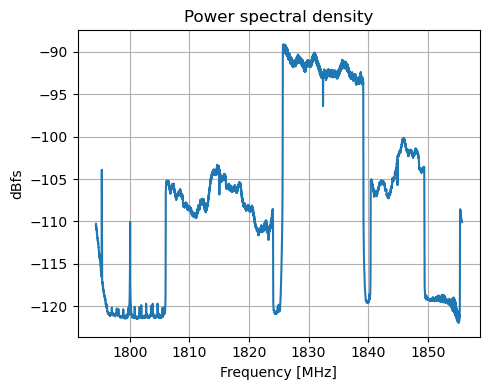

In [4]:
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4 ))

ax1.plot((np.array(sorted_freq_arr) + center_freq) / 1e6, 10*np.log10(np.array(sorted_rx_sig_psd_arr)))
ax1.grid()

ax1.set_title("Power spectral density")
ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("dBfs")
plt.tight_layout()

plt.savefig("figs/rx_psd.png", dpi=600, bbox_inches='tight')
plt.show()